In [1]:
%%capture
%cd ..

In [2]:
# Import data

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
ds_root_charge = 'dataset/soh_charge'
ds_root_discharge = 'dataset/soh_discharge'
colors = ['red', 'orange', 'blue', 'green', 'purple', 'lightblue']
file_names = []



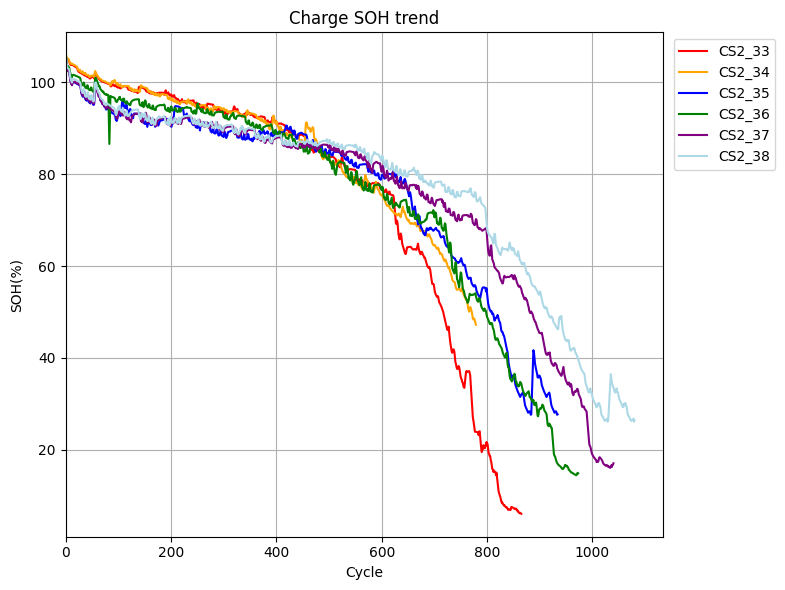

In [4]:

plt.figure(figsize=(8, 6))
plt_charge = plt.subplot(1, 1, 1)

# Controllo e rimozione delle righe con valori di SOH che si discostano troppo
for file_name in os.listdir(ds_root_charge):
    curr_path = f'{ds_root_charge}/{file_name}'
    if file_name.startswith('Csoh'):
        df_output = pd.read_csv(curr_path)
        valori_percentuali = (df_output['SOH'] / 1.1) * 100
        color = colors[len(plt_charge.lines) % len(colors)]
        cs2x_part = curr_path.split('-')[1].split('.csv')[0]

        plt_charge.plot(df_output['cycle'], valori_percentuali, label=f'{cs2x_part}', linestyle='-', color=color)

plt_charge.set_title('Charge SOH trend')
plt_charge.set_xlabel('Cycle')
plt_charge.set_ylabel('SOH(%)')

plt.xlim(left=0)
plt_charge.grid(True)
plt_charge.legend(loc='upper right', bbox_to_anchor=(1.2, 1.))

plt.tight_layout()
plt.show()

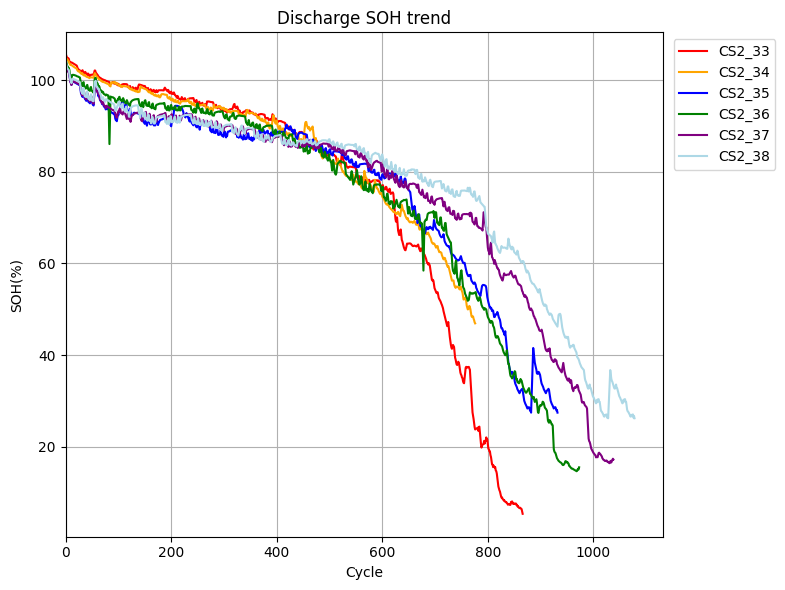

In [6]:

plt.figure(figsize=(8, 6))
plt_charge = plt.subplot(1, 1, 1)

# Controllo e rimozione delle righe con valori di SOH che si discostano troppo
for file_name in os.listdir(ds_root_discharge):
    curr_path = f'{ds_root_discharge}/{file_name}'
    if file_name.startswith('Dsoh'):
        df_output = pd.read_csv(curr_path)
        valori_percentuali = (df_output['SOH'] / 1.1) * 100
        color = colors[len(plt_charge.lines) % len(colors)]
        cs2x_part = curr_path.split('-')[1].split('.csv')[0]

        plt_charge.plot(df_output['cycle'],valori_percentuali,  label=f'{cs2x_part}', linestyle='-', color=color)

plt_charge.set_title('Discharge SOH trend')
plt_charge.set_xlabel('Cycle')
plt_charge.set_ylabel('SOH(%)')

plt.xlim(left=0)
plt_charge.grid(True)
plt_charge.legend(loc='upper right', bbox_to_anchor=(1.2, 1.))

plt.tight_layout()
plt.show()